Target: \
Build a lighter model with less than 10k parameter

Results: \
Parameters: 9,122 \
Best Train Accuracy: 99.20 \
Best Test Accuracy: 98.92

Analysis: \
Overfitting of lower degree as performance on test data is lower. \
Model was unable to reach the targetof 99.40 accuracy, needs some improvement in performance as well as stability.

# Import Libraries

In [ ]:
# load required libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

## Data Transformations


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                     ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1
batch_size = 64

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else \
                  dict(shuffle=True, batch_size=batch_size//2)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model

In [ ]:
# construct cnn class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 96, kernel_size = 5, padding = 2)  # apply 64 channel convolution with kernel size 5*5 on image
        self.conv2 = nn.Conv2d(96, 16, kernel_size = 1)  # apply 64 channel convolution with kernel size 1*1 on image
        self.conv3 = nn.Conv2d(16, 16, kernel_size = 3)  # apply 64 channel convolution with kernel size 3*3 on image
        self.conv4 = nn.Conv2d(16, 8, kernel_size = 1)  # apply 64 channel convolution with kernel size 1*1 on image
        self.conv5 = nn.Conv2d(8, 16, kernel_size = 3)  # apply 64 channel convolution with kernel size 3*3 on image
        self.conv6 = nn.Conv2d(16, 10, kernel_size = 3)  # apply 64 channel convolution with kernel size 3*3 on image
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, img):
        x = F.relu(self.conv1(img))  # input = 1 * 28 * 28, output = 96 * 28 * 28, rf = 5*5
        x = F.relu(self.conv2(x))  # input = 96 * 28 * 28, output = 16 * 28 * 28, rf = 5*5
        x = F.max_pool2d(x, 2)  # input = 16 * 28 * 28, output = 16 * 14 * 14, rf = 6*6

        x = F.relu(self.conv3(x))  # input = 16 * 14 * 14, output = 16 * 12 * 12, rf = 10*10
        x = F.relu(self.conv4(x))  # input = 16 * 12 * 12, output = 8 * 12 * 12, rf = 10*10
        x = F.max_pool2d(x, 2)  # input = 8 * 12 * 12, output = 8 * 6 * 6, rf = 12*12
        
        x = F.relu(self.conv5(x))  # input = 8 * 6 * 6, output = 16 * 4 * 4, rf = 20*20
        x = self.conv6(x)  # input = 16 * 4 * 4, output = 10 * 2 * 2, rf = 28*28
        x = self.gap(x)  # input = 10 * 2 *2, output = 10 * 1 * 1, rf = 32*32
        x = x.view(-1, 10)  # flatten cnn embedding

        img_out = F.log_softmax(x, dim = 1)  # output layer to output probabilities for label

        return img_out

# Model Params

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 28, 28]           2,496
            Conv2d-2           [-1, 16, 28, 28]           1,552
            Conv2d-3           [-1, 16, 12, 12]           2,320
            Conv2d-4            [-1, 8, 12, 12]             136
            Conv2d-5             [-1, 16, 4, 4]           1,168
            Conv2d-6             [-1, 10, 2, 2]           1,450
 AdaptiveAvgPool2d-7             [-1, 10, 1, 1]               0
Total params: 9,122
Trainable params: 9,122
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.70
Params size (MB): 0.03
Estimated Total Size (MB): 0.74
----------------------------------------------------------------


# Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, split="Test"):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        split, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.2808218002319336 Batch_id=937 Accuracy=74.59: 100%|██████████| 938/938 [00:18<00:00, 49.81it/s]



Test set: Average loss: 0.1389, Accuracy: 9567/10000 (95.67%)

EPOCH: 1


Loss=0.12248538434505463 Batch_id=937 Accuracy=96.44: 100%|██████████| 938/938 [00:17<00:00, 52.63it/s]



Test set: Average loss: 0.0961, Accuracy: 9676/10000 (96.76%)

EPOCH: 2


Loss=0.03541843593120575 Batch_id=937 Accuracy=97.33: 100%|██████████| 938/938 [00:15<00:00, 59.47it/s]



Test set: Average loss: 0.0548, Accuracy: 9821/10000 (98.21%)

EPOCH: 3


Loss=0.0024993405677378178 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:15<00:00, 59.67it/s]



Test set: Average loss: 0.0516, Accuracy: 9828/10000 (98.28%)

EPOCH: 4


Loss=0.007975039072334766 Batch_id=937 Accuracy=98.04: 100%|██████████| 938/938 [00:15<00:00, 59.06it/s]



Test set: Average loss: 0.0483, Accuracy: 9849/10000 (98.49%)

EPOCH: 5


Loss=0.009895645081996918 Batch_id=937 Accuracy=98.20: 100%|██████████| 938/938 [00:16<00:00, 57.56it/s]



Test set: Average loss: 0.0408, Accuracy: 9863/10000 (98.63%)

EPOCH: 6


Loss=0.09514982253313065 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [00:17<00:00, 54.76it/s]



Test set: Average loss: 0.0383, Accuracy: 9877/10000 (98.77%)

EPOCH: 7


Loss=0.0399777814745903 Batch_id=937 Accuracy=98.60: 100%|██████████| 938/938 [00:17<00:00, 52.77it/s]



Test set: Average loss: 0.0447, Accuracy: 9850/10000 (98.50%)

EPOCH: 8


Loss=0.02068287506699562 Batch_id=937 Accuracy=98.68: 100%|██████████| 938/938 [00:16<00:00, 57.33it/s]



Test set: Average loss: 0.0363, Accuracy: 9886/10000 (98.86%)

EPOCH: 9


Loss=0.017010947689414024 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:16<00:00, 56.56it/s]



Test set: Average loss: 0.0358, Accuracy: 9881/10000 (98.81%)

EPOCH: 10


Loss=0.04609169438481331 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:16<00:00, 57.02it/s]



Test set: Average loss: 0.0352, Accuracy: 9889/10000 (98.89%)

EPOCH: 11


Loss=0.0706559345126152 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:16<00:00, 57.79it/s]



Test set: Average loss: 0.0364, Accuracy: 9895/10000 (98.95%)

EPOCH: 12


Loss=0.0006923212204128504 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:16<00:00, 58.38it/s]



Test set: Average loss: 0.0293, Accuracy: 9910/10000 (99.10%)

EPOCH: 13


Loss=0.08996225893497467 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:16<00:00, 57.73it/s]



Test set: Average loss: 0.0366, Accuracy: 9880/10000 (98.80%)

EPOCH: 14


Loss=0.0003141901979688555 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:16<00:00, 55.71it/s]



Test set: Average loss: 0.0344, Accuracy: 9892/10000 (98.92%)



# Final Model Performance

In [ ]:
test(model, device, train_loader, split = "Train")


Train set: Average loss: 0.0241, Accuracy: 59523/60000 (99.20%)



In [ ]:
test(model, device, test_loader, split = "Test")


Test set: Average loss: 0.0344, Accuracy: 9892/10000 (98.92%)



# Performance Plots

Text(0.5, 1.0, 'Test Accuracy')

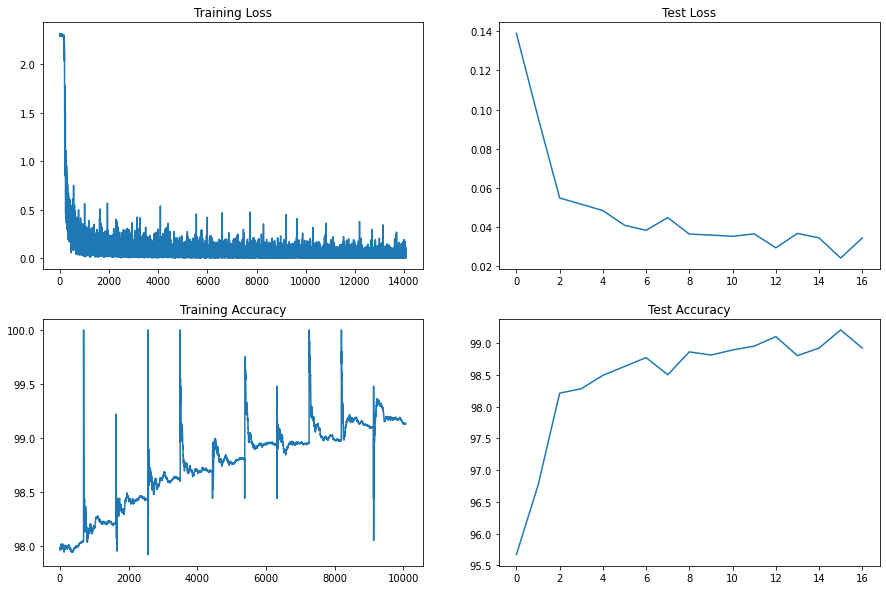

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")